<a href="https://colab.research.google.com/github/eliabrodsky/finance/blob/main/Python_portfolio_diversification_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective:
Find the minimal number of stocks to maximize portfolio rate of return and minimize portfolio variance

Steps:
- download NASDAQ100
- calculate Rates of Return for each Stock (Rates of return = (price(t) – price(t-1))/price(t-1))
- Calculate mean, st_dev, variance for each stock
- Prepare correlation and covariance matrices
- select top 30 stocks based on rate of returns
- remove most correlated stocks
- calculate portfolio mean and variance


In [1]:
pip install yfinance --q

     |████████████████████████████████| 62 kB 1.6 MB/s 


In [2]:
pip install dash --q

     |████████████████████████████████| 9.9 MB 13.4 MB/s 


In [3]:
pip install -U kaleido --q

     |████████████████████████████████| 79.9 MB 104 kB/s 


In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import cufflinks as cf
import plotly.io as pio
pio.renderers.default = "svg"

set list of tickers (can be manual or NASDAQ100)

In [8]:
start = '2021-09-08'
end = '2022-09-08'

#tickers = pd.read_csv('https://raw.githubusercontent.com/elabrodsky/portfolio/main/NASDQ100.csv', encoding = "ISO-8859-1")
tickers = ['META','AAPL','TSLA','MSFT']

#tickers = tickers.Ticker.to_list()
tickers

['META', 'AAPL', 'TSLA', 'MSFT']

In [9]:
df_yahoo = yf.download(tickers,
                       start=start,
                       end=end,
                       progress=True)

#df_yahoo.head()



[*********************100%***********************]  4 of 4 completed


In [10]:
Prices = df_yahoo.Open

In [11]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


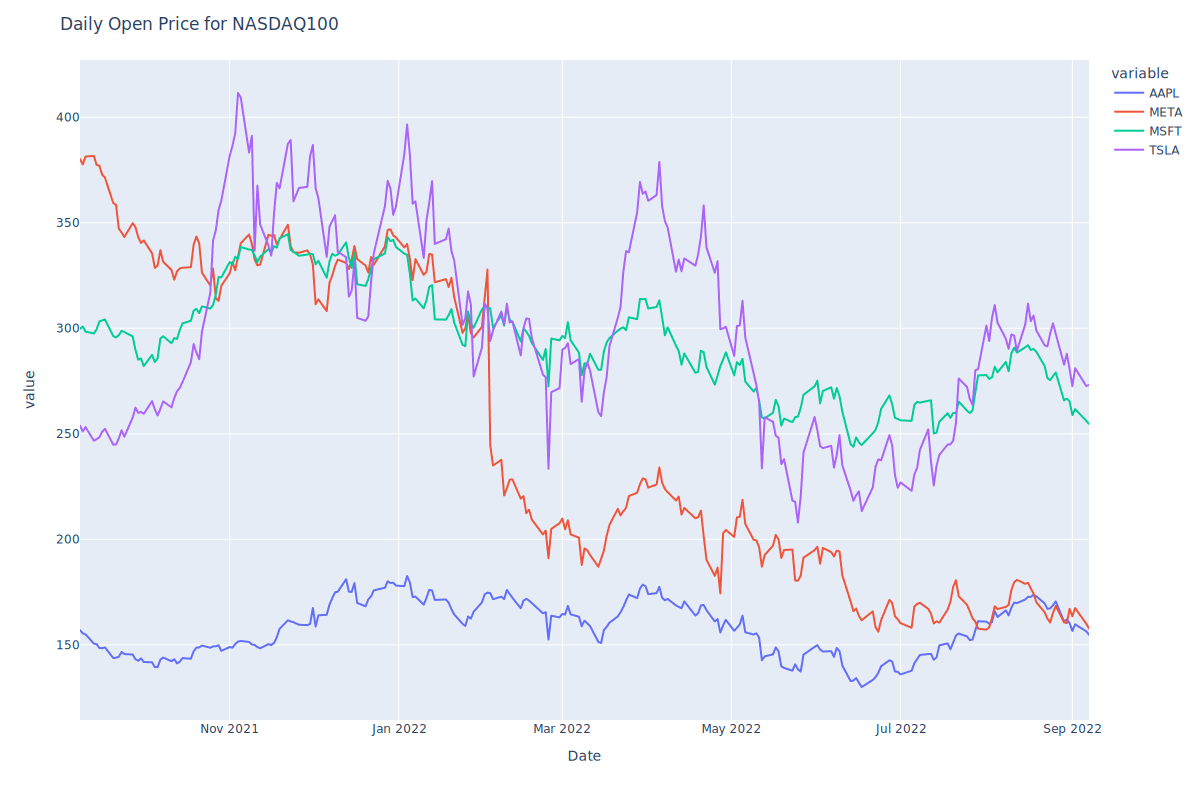

In [12]:
import plotly.express as px

OpenPrice = px.line(Prices)
OpenPrice.update_layout(title_text='Daily Open Price for NASDAQ100', width=1200, height=800)
OpenPrice.show("svg")

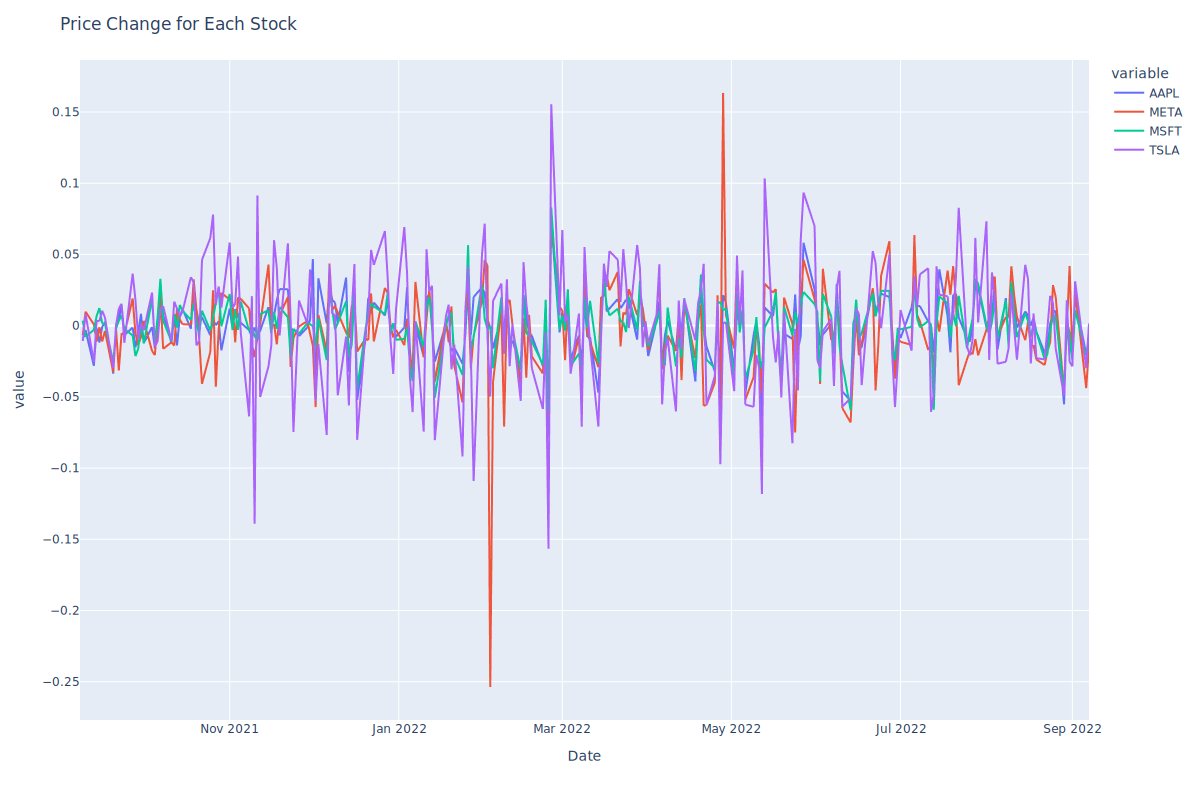

In [13]:
ChangePrice = Prices.pct_change(periods=1, fill_method='pad', limit=None, freq=None)

#plot PriceChange graph
PriceChangeGraph = px.line(ChangePrice)
PriceChangeGraph.update_layout(title_text='Price Change for Each Stock', width=1200, height=800)
PriceChangeGraph.show("svg")

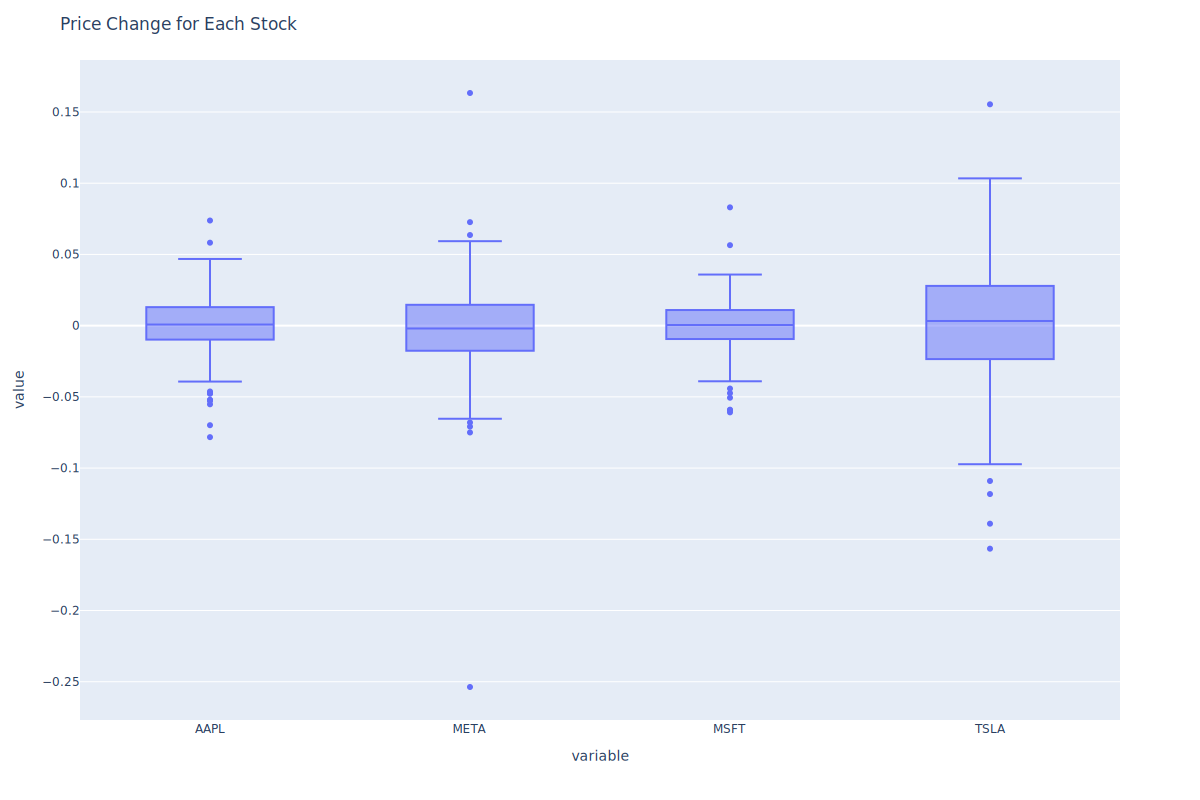

In [14]:
PriceChange = px.box(ChangePrice)
PriceChange.update_layout(title_text='Price Change for Each Stock', width=1200, height=800)
PriceChange.show("svg")

Standard deviation, mean

In [15]:
SumTable = pd.DataFrame()

#Calcualte Standard Deviation, Mean and Variance for each ticker
SumTable['St_dev'] = Prices.std()
SumTable['Mean'] = Prices.mean()
SumTable['Variance'] = Prices.var()

SumTable

,St_dev,Mean,Variance
AAPL,12.644342,158.136627,159.879385
META,74.165270,249.146508,5500.487276
MSFT,26.015334,293.772976,676.797579
TSLA,47.618910,297.684669,2267.560622


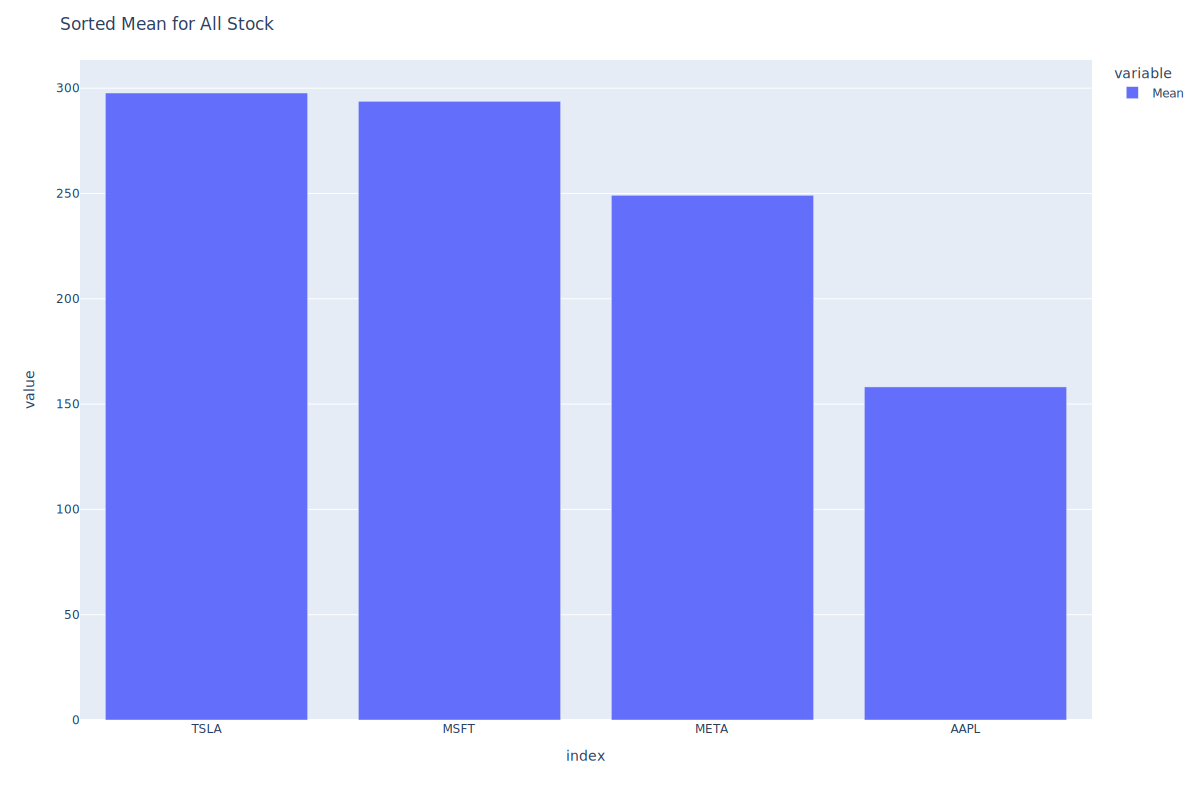

In [16]:
FolioGraph = px.bar(SumTable.Mean)
FolioGraph.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
FolioGraph.update_layout(title_text='Sorted Mean for All Stock', width=1200, height=800)
FolioGraph.show("svg")

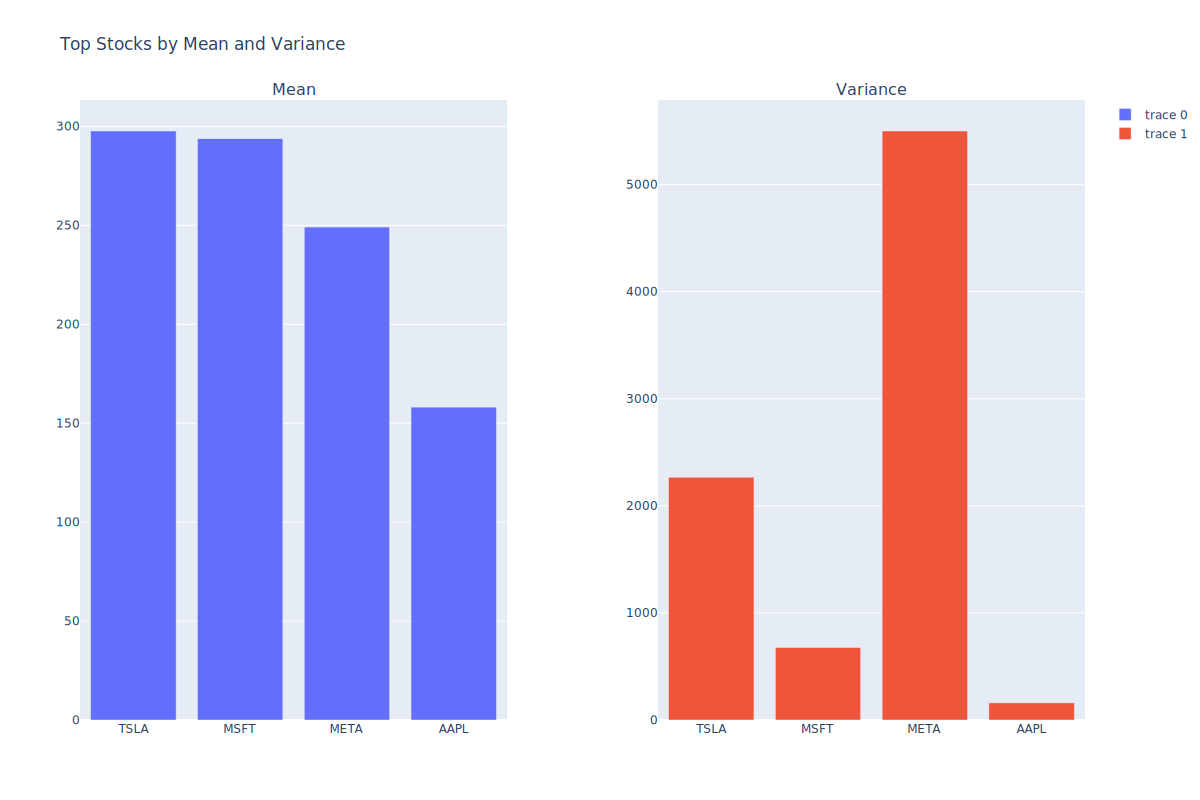

In [17]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#if to select based on a number
#topROI = SumTable[SumTable['Mean'] > 200]
#topROI.shape

#if to select top X number of stocks
topROI1 = SumTable.nlargest(30,['Mean'])
topROI1

topROI1Graph = make_subplots(1, 2, subplot_titles=('Mean', 'Variance'), horizontal_spacing=0.15)
topROI1Graph.add_trace(go.Bar(y=topROI1.Mean, x=topROI1.index), 1, 1)
topROI1Graph.add_trace(go.Bar(y=topROI1.Variance, x=topROI1.index), 1, 2)
topROI1Graph.update_layout(title_text='Top Stocks by Mean and Variance', width=1200, height=800)
topROI1Graph.show("svg")

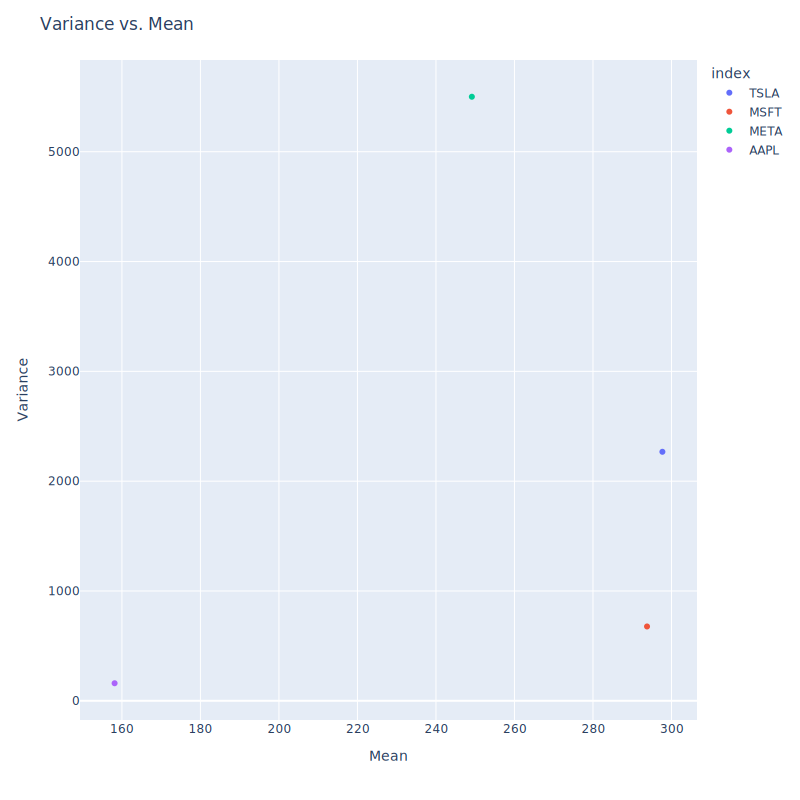

In [18]:
Paretto = px.scatter(topROI1, x="Mean",y="Variance", color=topROI1.index)
Paretto.update_layout(title_text='Variance vs. Mean', width = 800, height = 800)
Paretto.show("svg")

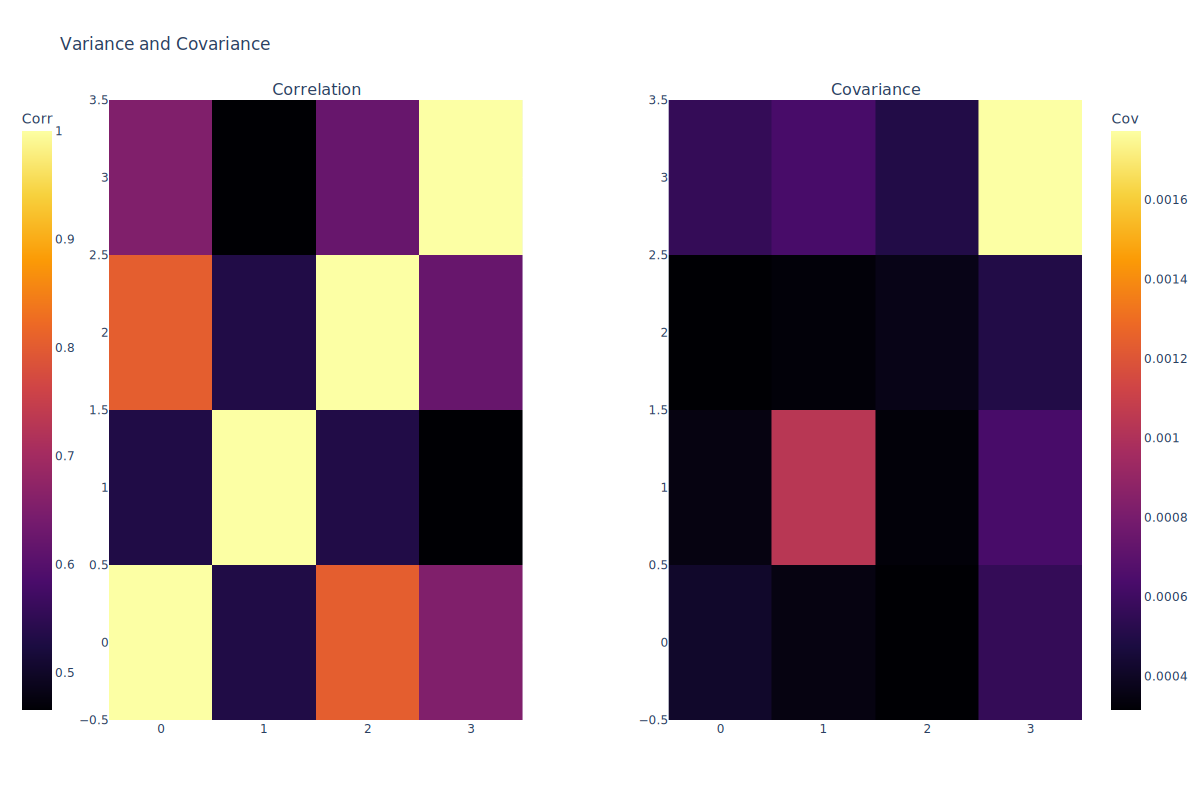

In [19]:
#correlation and covariance for each pair of stocks
Corr = ChangePrice.corr()
Covar = ChangePrice.cov()

fig = make_subplots(1, 2, subplot_titles=('Correlation', 'Covariance'), horizontal_spacing=0.15)
fig.add_trace(go.Heatmap(z=Corr, colorscale='Inferno', showscale=True, colorbar=dict(x=-0.1, title="Corr",titleside="top")), 1, 1)
fig.add_trace(go.Heatmap(z=Covar, colorscale='Inferno', showscale=True, colorbar=dict(title="Cov",titleside="top")), 1, 2)
fig.update_coloraxes(showscale=True)
fig.update_layout(title_text='Variance and Covariance', width=1200, height=800)
fig.show("svg")


In [20]:
upper_tri = Corr.where(np.triu(np.ones(Corr.shape),k=1).astype(bool))
print(upper_tri)

      AAPL      META      MSFT      TSLA
AAPL   NaN  0.531504  0.804441  0.653698
META   NaN       NaN  0.532828  0.465674
MSFT   NaN       NaN       NaN  0.622329
TSLA   NaN       NaN       NaN       NaN


remove stocks that are highly correlated from the list of top 30 companies

In [21]:
from operator import index
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
to_drop = list(to_drop)

topROI2 = topROI1[~topROI1.index.isin(to_drop)]
topROI2.head()

,St_dev,Mean,Variance
TSLA,47.618910,297.684669,2267.560622
META,74.165270,249.146508,5500.487276
AAPL,12.644342,158.136627,159.879385


start building portfolio

In [22]:
#set weights to portfolio
weights = 1/len(topROI2.index) #assign equal weights to each stock (1/number of stocks)
portfolio_stock = topROI2.index #select stocks from the top 26 selected (top 30 - top correlated)

portfolio = pd.DataFrame()
portfolio_stats = pd.DataFrame()


for stock in portfolio_stock:
  portfolio = portfolio.append(topROI2.loc[stock,])

portfolio['Weight'] = weights
adj_mean = []
adj_st_dev = []

for i in range(len(portfolio_stock)):
  adj_mean.append(portfolio.Mean[i]*portfolio.Weight[i])
  adj_st_dev.append(np.sqrt(portfolio.Variance[i])*portfolio.Weight[i])
  #print(adj_mean[i])

#portfolio['Stock'] = portfolio_stock
portfolio['Adj_Mean'] = adj_mean
portfolio['Adj_St_Dev'] = adj_st_dev

portfolio.head()

,St_dev,Mean,Variance,Weight,Adj_Mean,Adj_St_Dev
TSLA,47.618910,297.684669,2267.560622,0.333333,99.228223,15.872970
META,74.165270,249.146508,5500.487276,0.333333,83.048836,24.721757
AAPL,12.644342,158.136627,159.879385,0.333333,52.712209,4.214781


Covariance and Correlation matrix for selected stocks ("Top")

In [ ]:
CovarTop = Covar.loc[topROI2.index]
CovarTop = CovarTop[topROI2.index]

CorrTop = Corr.loc[topROI2.index]
CorrTop = CorrTop[topROI2.index]

CorrTop.head()

,BKNG,MELI,ORLY,REGN,CHTR,AVGO,PANW,COST,IDXX,INTU,...,LULU,ILMN,ODFL,TEAM,TSLA,ISRG,VRTX,ADSK,ZS,AMGN
BKNG,1.000000,0.545487,0.346800,0.198195,0.306455,0.539525,0.440535,0.372690,0.463299,0.489331,...,0.483951,0.414453,0.397714,0.539119,0.480891,0.507423,0.365814,0.565408,0.452289,0.198374
MELI,0.545487,1.000000,0.336236,0.259324,0.331948,0.580686,0.635463,0.451648,0.642085,0.702226,...,0.647505,0.615854,0.443103,0.751276,0.621200,0.640088,0.358421,0.700281,0.693554,0.159176
ORLY,0.346800,0.336236,1.000000,0.235262,0.365333,0.455768,0.336179,0.577327,0.467907,0.393130,...,0.426770,0.256464,0.447166,0.340124,0.269774,0.439842,0.298068,0.407579,0.325704,0.308017
REGN,0.198195,0.259324,0.235262,1.000000,0.174628,0.299775,0.281601,0.300535,0.388615,0.384788,...,0.356451,0.401707,0.188216,0.327313,0.212976,0.375168,0.443928,0.274210,0.295834,0.393106
CHTR,0.306455,0.331948,0.365333,0.174628,1.000000,0.300847,0.179063,0.331315,0.318426,0.287151,...,0.315945,0.220428,0.193530,0.311328,0.198134,0.298820,0.330841,0.315704,0.236206,0.278368


In [ ]:
portfolio

,St_dev,Mean,Variance,Weight,Adj_Mean,Adj_St_Dev
BKNG,235.283875,2218.111673,55358.501806,0.041667,92.421320,9.803495
MELI,330.936874,1124.258216,109519.214682,0.041667,46.844092,13.789036
ORLY,39.658451,659.208570,1572.792751,0.041667,27.467024,1.652435
REGN,40.472365,627.104564,1638.012298,0.041667,26.129357,1.686349
CHTR,104.571046,574.294960,10935.103747,0.041667,23.928957,4.357127
AVGO,47.797868,557.722261,2284.636208,0.041667,23.238428,1.991578
PANW,40.612518,523.608967,1649.376655,0.041667,21.817040,1.692188
COST,41.239589,512.934723,1700.703697,0.041667,21.372280,1.718316
IDXX,113.357395,504.947064,12849.899111,0.041667,21.039461,4.723225
INTU,90.676606,504.911786,8222.246965,0.041667,21.037991,3.778192


In [ ]:
Paretto = px.scatter(topROI1, x="Mean",y="Variance", color=topROI1.index)
Paretto.update_layout(title_text='Variance vs. Mean', width = 800, height = 800)
Paretto.show()

Calculate portfolio mean (add up adjusted means for each stock in the porfolio), adjusted means are means adjsuted for portfolio weights

In [ ]:
portfolio_mean = portfolio.Adj_Mean.sum(axis=0)
print("Portfolio mean is (sum of adjusted means for each stock) = ", portfolio_mean)

Portfolio mean is (sum of adjusted means for each stock) =  514.6899472506589


In [ ]:
portfolio_variance1 = []
portfolio_variance = []

#claculate the covariance value for each stock 

for stock in portfolio_stock:
  portfolio_variance1.append(portfolio.St_dev[stock]*np.prod(CorrTop[stock])) #multiply St.Dev. for each stock by the correlation row in the Corr matrix

portfolio_variance = np.sum(portfolio_variance1)+np.sum(portfolio['Adj_St_Dev'])

print("Portfolio Variance is (sum of adjusted St. Dev. and Covariances for each stock) = ", portfolio_variance)

Portfolio Variance is (sum of adjusted St. Dev. and Covariances for each stock) =  87.22766297550096


In [ ]:
d = {'Mean': [portfolio_mean], 'Variance': [portfolio_variance]}
portfolio_final = pd.DataFrame(data=d)
portfolio_final

Fig = px.bar(portfolio_final, barmode='group')
Fig.update_layout(title_text='Portfolio Stats')
Fig.show()

make a function to build portfolio and calculate portfolio mean and variance

In [ ]:

def build_Portfolio(stocks):

  #load basic data from the first SumTable
  portfolio_new = pd.DataFrame()
  portfolio_new = SumTable.loc[stocks]

  portfolio = pd.DataFrame()
  portfolio_stats = pd.DataFrame()

  #Set weights
  weights = 1/len(stocks) #assign equal weights to each stock (1/number of stocks)
  portfolio_stock = stocks #select stocks from the top 26 selected (top 30 - top correlated)

  for stock in portfolio_stock:
    portfolio = portfolio.append(SumTable.loc[stock,])

  portfolio['Weight'] = weights
  adj_mean = []
  adj_st_dev = []

  for i in range(len(portfolio_stock)):
    adj_mean.append(portfolio.Mean[i]*portfolio.Weight[i])
    adj_st_dev.append(np.sqrt(portfolio.Variance[i])*portfolio.Weight[i])

  #portfolio['Stock'] = portfolio_stock
  portfolio['Adj_Mean'] = adj_mean
  portfolio['Adj_St_Dev'] = adj_st_dev

  #Add adjusted St Dev and Mean values

  #prepare correlation and covariance matrices
  portfolio_mean = portfolio.Adj_Mean.sum(axis=0)

  CovarTop = Covar.loc[stocks]
  CovarTop = CovarTop[stocks]

  CorrTop = Corr.loc[stocks]
  CorrTop = CorrTop[stocks]

  #calcualte portfolio mean and variance
  portfolio_variance1 = []
  portfolio_variance = []

  #claculate the covariance value for each stock 
  for stock in portfolio_stock:
    portfolio_variance1.append(portfolio.St_dev[stock]*np.prod(CorrTop[stock])) #multiply St.Dev. for each stock by the correlation row in the Corr matrix
  portfolio_variance = np.sum(portfolio_variance1)+np.sum(portfolio['Adj_St_Dev'])
  
  return portfolio_mean


In [ ]:
build_Portfolio(['AAPL','AMZN'])
#portfolio_new.head()


152.97282243153404